In [1]:
import datetime
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import (
    StandardScaler
)

from sklearn.svm import OneClassSVM

import joblib

# Config

In [2]:
SEQ_LEN = 240         
PERIOD_SAMPLES = 2880

BATCH_SIZE = 64 
EPOCHS = 1

LEARNING_RATE = 1e-3
VAL_RATIO = 0.1

# Data loading 

In [3]:
current_dir = Path.cwd()
df = pd.read_csv(current_dir.parent / 'data' / 'train_residuals.csv')

with open(current_dir.parent / 'data' / 'metrics.json', 'r') as f:
    METRIC_NAMES = json.load(f)
    
N_FEATURES = len(METRIC_NAMES) 


# Data procession 

In [4]:
scaled_residuals_df = pd.DataFrame(index=df.index)
scaler_map ={}

for metric in METRIC_NAMES:
    scaler = StandardScaler()
    scaled_col = scaler.fit_transform(df[[metric]])
    scaled_residuals_df[metric] = scaled_col.flatten()
    scaler_map[metric] = scaler

In [5]:
def create_sliding_windows(data, seq_len):
    sequences = []
    for i in range(len(data) - seq_len):
        sequences.append(data[i:i+seq_len])
    return np.array(sequences)

X = create_sliding_windows(scaled_residuals_df, SEQ_LEN)
print(f"X shape : {X.shape}")  

X shape : (60235, 240, 6)


In [6]:
n_samples = X.shape[0]
n_timesteps = X.shape[1] # 240
n_features = X.shape[2]  # 7

X_flat = X.reshape(n_samples, n_timesteps * n_features)

print(f"X shape for SVM: {X_flat.shape}")

X shape for SVM: (60235, 1440)


# Train model

In [7]:
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
ocsvm.fit(X_flat)

,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,nu,0.05
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [8]:

train_scores = ocsvm.decision_function(X_flat)

In [17]:

print(f"SVM score range: from {train_scores.min():.4f} to {train_scores.max():.4f}")

SVM score range: from -1.0842 to 18.6341


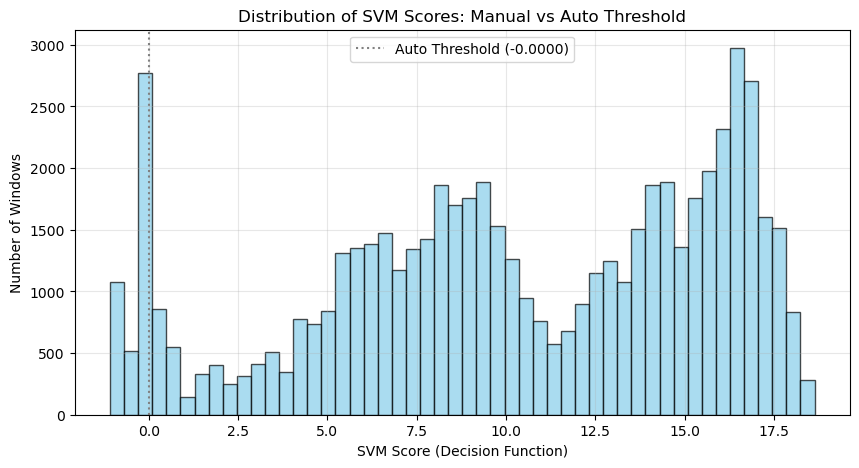

In [18]:
plt.figure(figsize=(10, 5))
plt.hist(train_scores, bins=50, color='skyblue', edgecolor='black', alpha=0.7)


auto_thresh = np.quantile(train_scores, 0.05)
plt.axvline(auto_thresh, color='gray', linestyle=':', label=f'Auto Threshold ({auto_thresh:.4f})')

plt.title('Distribution of SVM Scores: Manual vs Auto Threshold')
plt.xlabel('SVM Score (Decision Function)')
plt.ylabel('Number of Windows')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

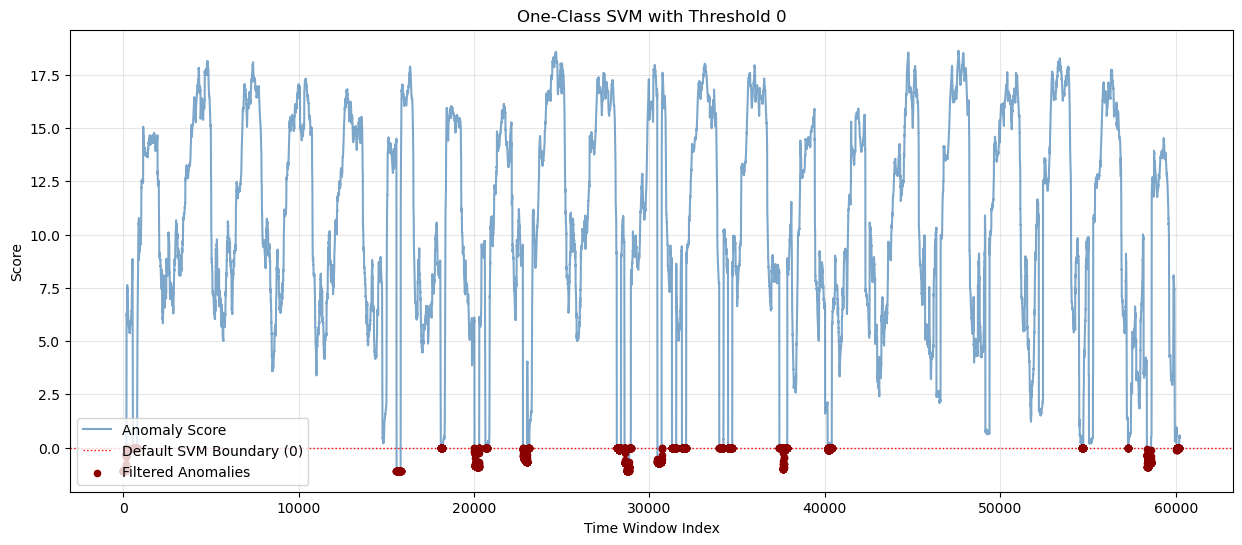

In [22]:
plt.figure(figsize=(15, 6))
plt.plot(train_scores, label='Anomaly Score', alpha=0.7, color='steelblue')
plt.axhline(0, linestyle=':', linewidth=1, color='red', label='Default SVM Boundary (0)')
real_anom_indices = np.where(train_scores < 0)[0]
plt.scatter(real_anom_indices, train_scores[real_anom_indices], color='darkred', s=20, zorder=5, label='Filtered Anomalies')

plt.title(f'One-Class SVM with Threshold 0')
plt.xlabel('Time Window Index')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Savings 

In [12]:
current_dir = Path.cwd()
save_dir = current_dir.parent / "models" / "ocsvm"
save_dir.mkdir(parents=True, exist_ok=True)
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

In [13]:
model_filename = f"ocsvm_anomaly_detector_{timestamp}.pkl"

joblib.dump(ocsvm, save_dir / model_filename)
print(f"Model is SAVED: {model_filename}")

Model is SAVED: ocsvm_anomaly_detector_20260213_194751.pkl


In [14]:
scaler_filename = f"ocsvm_anomaly_scaler_map_{timestamp}.pkl"

joblib.dump(scaler_map, save_dir / scaler_filename)

['c:\\Users\\Користувач\\Jupyter\\server-metrics-anomaly-detection\\models\\ocsvm\\ocsvm_anomaly_scaler_map_20260213_194751.pkl']

In [23]:
scores_filename = f"ocsvm_anomaly_train_scores_{timestamp}.npy"
np.save(save_dir / scores_filename,  train_scores)


In [ ]:
params_filename = f"ocsvm_anomaly_parameters_{timestamp}.txt"

params = {
    "MODEL_TYPE": "OneClassSVM",
    "METRIC_NAMES": METRIC_NAMES,
    "SEQ_LEN": SEQ_LEN,
    "nu": ocsvm.nu,
    "gamma": ocsvm.gamma,
    "kernel": ocsvm.kernel,
    "n_samples_train": X_flat.shape[0],
    "n_features_input": X_flat.shape[1], # (SEQ_LEN * 7)
    "n_support_vectors": int(ocsvm.support_.shape[0]), 
    "intercept": float(ocsvm.intercept_[0]),
    "SCALER_TYPE": type(next(iter(scaler_map.values()))).__name__,
    "trained at": timestamp
}

with open(save_dir / params_filename, "w") as f:
    json.dump(params, f, indent=4)
